# Classification

In [12]:
!pip install gensim

In [13]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [14]:
df = pd.read_csv("/content/Twitter_Emotion_Dataset.csv")
df.head

<bound method NDFrame.head of         label                                              tweet
0       anger  Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...
1       anger  Sesama cewe lho (kayaknya), harusnya bisa lebi...
2       happy  Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
3       anger  Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...
4       happy  Sharing pengalaman aja, kemarin jam 18.00 bata...
...       ...                                                ...
4396     love  Tahukah kamu, bahwa saat itu papa memejamkan m...
4397     fear  Sulitnya menetapkan Calon Wapresnya Jokowi di ...
4398    anger  5. masa depannya nggak jelas. lha iya, gimana ...
4399    happy  [USERNAME] dulu beneran ada mahasiswa Teknik U...
4400  sadness  Ya Allah, hanya Engkau yang mengetahui rasa sa...

[4401 rows x 2 columns]>


--- Distribusi Kelas Emosi ---
label
anger      1101
happy      1017
sadness     997
fear        649
love        637
Name: count, dtype: int64
Grafik distribusi emosi disimpan sebagai 'emotion_distribution.png'


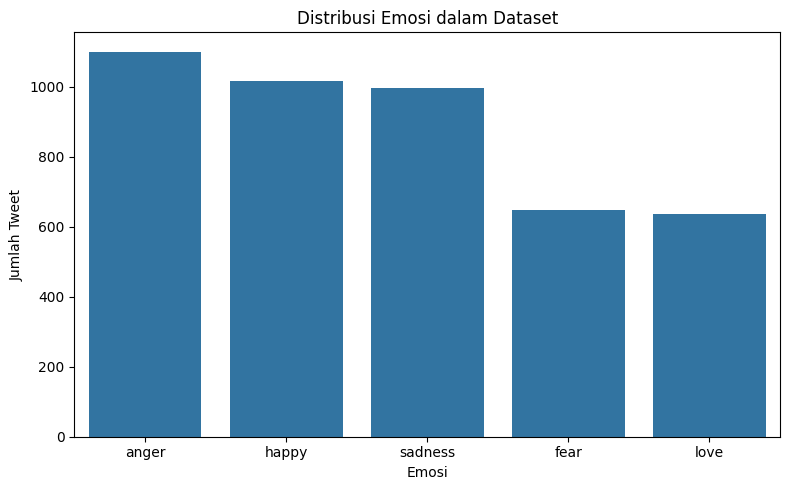

In [15]:
# Tampilkan distribusi kelas untuk melihat imbalance
print("\n--- Distribusi Kelas Emosi ---")
print(df['label'].value_counts())
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df, order=df['label'].value_counts().index)
plt.title('Distribusi Emosi dalam Dataset')
plt.ylabel('Jumlah Tweet')
plt.xlabel('Emosi')
plt.tight_layout()
plt.savefig('emotion_distribution.png')
print("Grafik distribusi emosi disimpan sebagai 'emotion_distribution.png'")

In [16]:
# 1. PERSIAPAN KAMUS DAN STOPWORD UNTUK PREPROCESSING

# Muat kamus alay dan ubah menjadi dictionary
alay_df = pd.read_csv("/content/kamus_alay.csv")
alay_dict = dict(zip(alay_df["slang"], alay_df["formal"]))
# Daftar stopword yang Anda berikan
stopwords_list_string = """
ada adalah adanya adapun agak agaknya agar akan akankah akhir akhiri akhirnya aku akulah amat amatlah anda andalah antar antara antaranya apa apaan apabila apakah apalagi apatah artinya asal asalkan atas atau ataukah ataupun awal awalnya bagai bagaikan bagaimana bagaimanakah bagaimanapun bagi bagian bahkan bahwa bahwasanya baik bakal bakalan balik banyak bapak baru bawah beberapa begini beginian beginikah beginilah begitu begitukah begitulah begitupun bekerja belakang belakangan belum belumlah benar benarkah benarlah berada berakhir berakhirlah berakhirnya berapa berapakah berapalah berapapun berarti berawal berbagai berdatangan beri berikan berikut berikutnya berjumlah berkali-kali berkata berkehendak berkeinginan berkenaan berlainan berlalu berlangsung berlebihan bermacam bermacam-macam bermaksud bermula bersama bersama-sama bersiap bersiap-siap bertanya bertanya-tanya berturut berturut-turut bertutur berujar berupa besar betul betulkah biasa biasanya bila bilakah bisa bisakah boleh bolehkah bolelah buat bukan bukankah bukanlah bukannya bulan bung cara caranya cukup cukupkah cukuplah cuma dahulu dalam dan dapat dari daripada datang dekat demi demikian demikianlah dengan depan di dia diakhiri diakhirinya dialah diantara diantaranya diberi diberikan diberikannya dibuat dibuatnya didapat didatangkan digunakan diibaratkan diibaratkannya diingat diingatkan diinginkan dijawab dijelaskan dijelaskannya dikarenakan dikatakan dikatakannya dikerjakan diketahui diketahuinya dikira dilakukan dilalui dilihat dimaksud dimaksudkan dimaksudkannya dimaksudnya diminta dimintai dimisalkan dimulai dimulailah dimulainya dimungkinkan dini dipastikan diperbuat diperbuatnya dipergunakan diperkirakan diperlihatkan diperlukan diperlukannya dipersoalkan dipertanyakan dipunyai diri dirinya disampaikan disebut disebutkan disebutkannya disini disinilah ditambahkan ditandaskan ditanya ditanyai ditanyakan ditegaskan ditujukan ditunjuk ditunjuki ditunjukkan ditunjukkannya ditunjuknya dituturkan dituturkannya diucapkan diucapkannya diungkapkan dong dua dulu empat enggak enggaknya entah entahlah guna gunakan hal hampir hanya hanyalah hari harus haruslah harusnya hendak hendaklah hendaknya hingga ia ialah ibarat ibaratkan ibaratnya ibu ikut ingat ingat-ingat ingin inginkah inginkan ini inikah inilah itu itukah itulah jadi jadilah jadinya jangan jangankan janganlah jauh jawab jawaban jawabnya jelas jelaskan jelaslah jelasnya jika jikalau juga jumlah jumlahnya justru kala kalau kalaulah kalaupun kalian kami kamilah kamu kamulah kan kapan kapankah kapanpun karena karenanya kasus kata katakan katakanlah katanya ke keadaan kebetulan kecil kedua keduanya keinginan kelamaan kelihatan kelihatannya kelima keluar kembali kemudian kemungkinan kemungkinannya kenapa kepada kepadanya kesampaian keseluruhan keseluruhannya keterlaluan ketika khususnya kini kinilah kira kira-kira kiranya kita kitalah kok kurang lagi lagian lah lain lainnya lalu lama lamanya lanjut lanjutnya lebih lewat lima luar macam maka makanya makin malah malahan mampu mampukah mana manakala manalagi masa masalah masalahnya masih masihkah masing masing-masing mau maupun melainkan melakukan melalui melihat melihatnya memang memastikan memberi memberikan membuat memerlukan memihak meminta memintakan memisalkan memperbuat mempergunakan memperkirakan memperlihatkan mempersiapkan mempersoalkan mempertanyakan mempunyai memulai memungkinkan menaiki menambahkan menandaskan menanti menanti-nanti menantikan menanya menanyai menanyakan mendapat mendapatkan mendatang mendatangi mendatangkan menegaskan mengakhiri mengapa mengatakan mengatakannya mengenai mengerjakan mengetahui menggunakan menghendaki mengibaratkan mengibaratkannya mengingat mengingatkan menginginkan mengira mengucapkan mengucapkannya mengungkapkan menjadi menjawab menjelaskan menuju menunjuk menunjuki menunjukkan menunjuknya menurut menuturkan menyampaikan menyangkut menyatakan menyebutkan menyeluruh menyiapkan merasa mereka merekalah merupakan meski meskipun meyakini meyakinkan minta mirip misal misalkan misalnya mula mulai mulailah mulanya mungkin mungkinkah nah naik namun nanti nantinya nyaris nyatanya oleh olehnya pada padahal padanya pak paling panjang pantas para pasti pastilah penting pentingnya per percuma perlu perlukah perlunya pernah persoalan pertama pertama-tama pertanyaan pertanyakan pihak pihaknya pukul pula pun punya rasa rasanya rata rupanya saat saatnya saja sajalah saling sama sama-sama sambil sampai sampai-sampai sampaikan sana sangat sangatlah satu saya sayalah se sebab sebabnya sebagai sebagaimana sebagainya sebagian sebaik sebaik-baiknya sebaiknya sebaliknya sebanyak sebegini sebegitu sebelum sebelumnya sebenarnya seberapa sebesar sebetulnya sebisanya sebuah sebut sebutlah sebutnya secara secukupnya sedang sedangkan sedemikian sedikit sedikitnya seenaknya segala segalanya segera seharusnya sehingga seingat sejak sejauh sejenak sejumlah sekadar sekadarnya sekali sekali-kali sekalian sekaligus sekalipun sekarang sekarang sekecil seketika sekiranya sekitar sekitarnya sekurang-kurangnya sekurangnya sela selain selaku selalu selama selama-lamanya selamanya selanjutnya seluruh seluruhnya semacam semakin semampu semampunya semasa semasih semata semata-mata semaunya sementara semisal semisalnya sempat semua semuanya semula sendiri sendirian sendirinya seolah seolah-olah seorang sepanjang sepantasnya sepantasnyalah seperlunya seperti sepertinya sepihak sering seringnya serta serupa sesaat sesama sesampai sesegera sesekali seseorang sesuatu sesuatunya sesudah sesudahnya setelah setempat setengah seterusnya setiap setiba setibanya setidak-tidaknya setidaknya setinggi seusai sewaktu siap siapa siapakah siapapun sini sinilah soal soalnya suatu sudah sudahkah sudahlah supaya tadi tadinya tahu tahun tak tambah tambahnya tampak tampaknya tandas tandasnya tanpa tanya tanyakan tanyanya tapi tegas tegasnya telah tempat tengah tentang tentu tentulah tentunya tepat terakhir terasa terbanyak terdahulu terdapat terdiri terhadap terhadapnya teringat teringat-ingat terjadi terjadilah terjadinya terkira terlalu terlebih terlihat termasuk ternyata tersampaikan tersebut tersebutlah tertentu tertuju terus terutama tetap tetapi tiap tiba tiba-tiba tidak tidakkah tidaklah tiga tinggi toh tunjuk turut tutur tuturnya ucap ucapnya ujar ujarnya umum umumnya ungkap ungkapnya untuk usah usai waduh wah wahai waktu waktunya walau walaupun wong yaitu yakin yakni yang
"""
# Ubah string menjadi set untuk pencarian yang lebih cepat
stopwords_set = set(stopwords_list_string.strip().split())

In [17]:
# 2. FUNGSI PREPROCESSING

def preprocess_tweet(tweet: str, alay_dict: dict, stopwords_set: set) -> str:
    # 1. Case Folding (mengubah semua huruf menjadi huruf kecil)
    tweet = tweet.lower()

    # 2. Cleansing (hapus URL, mention, hashtag, angka, dan tanda baca)
    tweet = re.sub(r"\[url\]|\[username\]|#\w+|\d+", "", tweet)
    tweet = re.sub(r"[^\w\s]", "", tweet)

    # 3. Tokenization (pemisahan kata)
    tokens = tweet.split()

    # 4. Normalization and Stopword Removal
    processed_tokens = []
    for token in tokens:
        # Normalisasi kata alay
        normalized_token = alay_dict.get(token, token)

        # Hapus stopwords
        if normalized_token not in stopwords_set:
            processed_tokens.append(normalized_token)

    # Gabungkan kembali token menjadi kalimat
    return " ".join(processed_tokens)

df['cleaned_tweet'] = df['tweet'].apply(lambda x: preprocess_tweet(x, alay_dict, stopwords_set))

# Encode Label
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

In [18]:
# 3. FEATURE EXTRACTION DENGAN TF-IDF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=3, max_df=0.9, max_features=10000)
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_tweet'])

# 4. PEMBAGIAN DATA
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

Penjelasan: Dilakukan dua ekstraksi fitur, yaitu TF-IDF dan Word2Vec, untuk membuat perbandingan antara pemodelan yang menggunakan ekstraksi fitur yang tidak mempertimbangkan konteks dan makna (TF-IDF), serta pemodelan yang menggunakan ekstrakssi fitur yang memahami makna dan konteks (Word2vec).

In [19]:
# 5. PEMBAGIAN DATA & PENERAPAN SMOTE
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)
smote_tfidf = SMOTE(random_state=42)
X_train_resampled_tfidf, y_train_resampled_tfidf = smote_tfidf.fit_resample(X_train_tfidf, y_train)

In [20]:
# 6. PEMODELAN DAN TUNING

# 6a. SVM
print("\n" + "="*50)
print("MEMULAI TUNING UNTUK SVM (DATA SMOTE)")
print("="*50)
param_grid_svm = {'C': [1, 10], 'kernel': ['linear', 'rbf']}
grid_search_svm = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=3, n_jobs=-1, verbose=2)
grid_search_svm.fit(X_train_resampled_tfidf, y_train_resampled_tfidf)
best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_tfidf)
print("\n--- Hasil Terbaik SVM (Tuning + SMOTE) ---")
print(f"Parameter Terbaik: {grid_search_svm.best_params_}")
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_))

# 6b. Logistic Regression
print("\n" + "="*50)
print("MEMULAI TUNING UNTUK LOGISTIC REGRESSION (DATA SMOTE)")
print("="*50)
param_grid_lr = {'C': [1, 10, 100], 'solver': ['liblinear', 'saga']}
grid_search_lr = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), param_grid_lr, cv=3, n_jobs=-1, verbose=2)
grid_search_lr.fit(X_train_resampled_tfidf, y_train_resampled_tfidf)
best_lr = grid_search_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_tfidf)
print("\n--- Hasil Terbaik Logistic Regression (Tuning + SMOTE) ---")
print(f"Parameter Terbaik: {grid_search_lr.best_params_}")
print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))

# 6c. Random Forest
print("\n" + "="*50)
print("MEMULAI TUNING UNTUK RANDOM FOREST (DATA SMOTE)")
print("="*50)
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [50, None], 'min_samples_split': [2, 5]}
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train_resampled_tfidf, y_train_resampled_tfidf)
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_tfidf)
print("\n--- Hasil Terbaik Random Forest (Tuning + SMOTE) ---")
print(f"Parameter Terbaik: {grid_search_rf.best_params_}")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))


MEMULAI TUNING UNTUK SVM (DATA SMOTE)
Fitting 3 folds for each of 4 candidates, totalling 12 fits

--- Hasil Terbaik SVM (Tuning + SMOTE) ---
Parameter Terbaik: {'C': 10, 'kernel': 'rbf'}
              precision    recall  f1-score   support

       anger       0.61      0.77      0.68       220
        fear       0.85      0.59      0.70       130
       happy       0.63      0.59      0.61       204
        love       0.88      0.60      0.71       127
     sadness       0.46      0.54      0.49       200

    accuracy                           0.62       881
   macro avg       0.68      0.62      0.64       881
weighted avg       0.65      0.62      0.63       881


MEMULAI TUNING UNTUK LOGISTIC REGRESSION (DATA SMOTE)
Fitting 3 folds for each of 6 candidates, totalling 18 fits

--- Hasil Terbaik Logistic Regression (Tuning + SMOTE) ---
Parameter Terbaik: {'C': 10, 'solver': 'liblinear'}
              precision    recall  f1-score   support

       anger       0.64      0.68      0

Penjelasan: Dilakukan tuning grid search pada ketiga model agar dapat langsung mendapatkan parameter terbaik.

SVM mendapat akurasi 62% dan f1-skor average 0.64, ini menunjukkan jika model ini cukup balance dalam mengklasifikasikan tiap kelas. Bahkan untuk kelas minoritas seperti love dan fear mendapat precision sekitar 0.8 yang berarti model sering benar menebak kelas tersebut. Namun, recall untuk love dan fear masih rendah, yaitu sekitar 0.5-0.6, yang berarti model masih banyak melewatkan data dengan kelas tersebut. Selain itu, kelas sadness memiliki skor paling rendah di antara kelas lain, yang berarti model masih sulit mendeteksi kelas ini.

Logistic regression juga mendapat akurasi dan f1-score yang sama dengan SVM, yaitu 62% dan 0.64, ini menunjukkan bahwa model logistic regression ini juga seimbang dalam mengklasifikasikan kelas. Secara keseluruhan, precision dan recall di tiap kelas cukup seimbang dibandingkan dengan SVM.

Random forest mendapat akurasi 61% dan f1-score average 0.63, model ini mendapat akurasi paling rendah dibandingkan dengan kedua model lainnya. Namun, random forest mendapat f1-score yang paling tinggi untuk kelas love dan fear, menunjukkan bahwa model ini paling baik dalam mengklasifikasikan kelas minoritas. Namun, dalam mengklasifikasikan kelas mayoritas, model ini tidak begitu baik.



### Kesimpulan Classification

Model klasifikasi biasa yang paling baik untuk dataset ini adalah logistic regression karena mendapat akurasi paling tinggi, yaitu 62%. Meskipun SVM juga mendapat akurasi yang sama, skor classification report logistic regression lebih seimbang di semua kelas daripada SVM.

Meski begitu, hasil pemodelan secara keseluruhan masih belum begitu baik dan optimal, sehingga perlu dilakukan percobaan model lain menggunakan deep learning.

# Deep Learning



## 1D CNN

In [21]:
import pandas as pd
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import class_weight

# 1. SETUP DAN PREPROCESSING
# Muat data
try:
    df = pd.read_csv('Twitter_Emotion_Dataset.csv')
    alay_df = pd.read_csv('kamus_alay.csv')
    alay_dict = dict(zip(alay_df['slang'], alay_df['formal']))
    print("Dataset dan kamus alay berhasil dimuat.")
except FileNotFoundError:
    print("File CSV tidak ditemukan.")
    exit()

# Fungsi preprocessing (tidak menghapus stopwords)
def preprocess_for_dl(tweet: str, alay_dict: dict) -> str:
    tweet = str(tweet)
    # 1. Case folding (mengubah semua huruf menjadi huruf kecil)
    tweet = tweet.lower()
    # 2. Hapus noise (URL, username, hashtag, angka)
    tweet = re.sub(r'\[url\]|\[username\]|#\w+|\d+', '', tweet)
    # 3. Hapus tanda baca
    tweet = re.sub(r'[^\w\s]', '', tweet)
    # 4. Normalisasi kata alay
    tokens = tweet.split()
    normalized_tokens = [alay_dict.get(token, token) for token in tokens]

    return ' '.join(normalized_tokens)

print("\nMemulai preprocessing yang disesuaikan untuk Deep Learning...")
df['cleaned_tweet'] = df['tweet'].apply(lambda x: preprocess_for_dl(x, alay_dict))
print("Preprocessing selesai.")


# 2. PERSIAPAN DATA
# Ekstraksi fitur dengan embedding
MAX_WORDS = 10000
MAX_LEN = 50
EMBEDDING_DIM = 128

tokenizer = Tokenizer(num_words=MAX_WORDS, lower=True)
tokenizer.fit_on_texts(df['cleaned_tweet'].values)

X_seq = tokenizer.texts_to_sequences(df['cleaned_tweet'].values)
X_pad = pad_sequences(X_seq, maxlen=MAX_LEN)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])
word_index = tokenizer.word_index


# 3. IMBALANCE HANDLING DENGAN CLASS WEIGHT
# Menghitung bobot untuk setiap kelas agar model memberi perhatian lebih pada kelas minoritas
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
# Mengubahnya menjadi format dictionary yang bisa dibaca Keras
class_weights = dict(enumerate(class_weights_array))

print("\nClass Weights yang akan digunakan untuk Imbalance Handling:")
print(class_weights)


# 4. MEMBANGUN MODEL 1D CNN
model_cnn_final = Sequential()
model_cnn_final.add(Embedding(input_dim=min(MAX_WORDS, len(word_index) + 1),
                                output_dim=EMBEDDING_DIM,
                                input_length=MAX_LEN))
model_cnn_final.add(Conv1D(128, 5, activation='relu'))
model_cnn_final.add(GlobalMaxPooling1D())
model_cnn_final.add(Dense(128, activation='relu'))
model_cnn_final.add(Dropout(0.5))
model_cnn_final.add(Dense(len(label_encoder.classes_), activation='softmax'))

model_cnn_final.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("\nArsitektur Model 1D CNN:")
model_cnn_final.summary()


# 5. MEMBAGI DATA, MELATIH, DAN MENGEVALUASI
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42, stratify=y)

print("\nMemulai pelatihan model...")
callbacks = [EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]

history_final = model_cnn_final.fit(X_train, y_train,
                                    epochs=15,
                                    batch_size=64,
                                    validation_data=(X_test, y_test),
                                    callbacks=callbacks,
                                    class_weight=class_weights) # Menerapkan imbalance handling di sini

print("\nPelatihan selesai.")

# 6. EVALUASI
print("\n--- Hasil Evaluasi 1D CNN (dengan Penyesuaian) ---")
y_pred_probs = model_cnn_final.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print(f"Akurasi: {accuracy_score(y_test, y_pred):.4f}")
print("\nLaporan Klasifikasi:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Dataset dan kamus alay berhasil dimuat.

Memulai preprocessing yang disesuaikan untuk Deep Learning...
Preprocessing selesai.

Class Weights yang akan digunakan untuk Imbalance Handling:
{0: np.float64(0.7994550408719346), 1: np.float64(1.3562403697996919), 2: np.float64(0.8654867256637168), 3: np.float64(1.3817896389324962), 4: np.float64(0.8828485456369107)}

Arsitektur Model 1D CNN:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Memulai pelatihan model...
Epoch 1/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.1927 - loss: 1.6133 - val_accuracy: 0.2770 - val_loss: 1.5255
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4531 - loss: 1.3386 - val_accuracy: 0.5414 - val_loss: 1.2143
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6649 - loss: 0.9189 - val_accuracy: 0.6129 - val_loss: 1.0154
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8703 - loss: 0.5108 - val_accuracy: 0.6311 - val_loss: 0.9932
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9694 - loss: 0.1776 - val_accuracy: 0.6243 - val_loss: 1.0527
Epoch 6/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9907 - loss: 0.0671 - val_accuracy: 0.6334 - val_loss: 1.1337
Epoch 7/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9959 - loss: 0.0389 - val_accuracy: 0.6322 - val_loss: 1.2320

Pelatihan selesai.

--- Hasil Evaluasi 1D CNN (dengan Penyesuaian) ---
28/28 ━━━━━━━━━━━

Penjelasan: Model 1D CNN mendapat akurasi dan f1-score average yang sedikit lebih tinggi daripada model klasifikasi biasa, yaitu 63% dan 0.65, ini menunjukkan bahwa model deep learning ini mampu menangkap pola data yang lebih kompleks daripada model biasa.

Pada kelas love, precision dan recall-nya cukup tinggi dan seimbang, yaitu 0.7, yang berarti model cukup baik dalam mengklasifikasikan tweet love.

Pada kelas fear, precision cukup tinggi, yaitu 0.82, namun recall-nya cukup rendah, sehingga tidak seimbang.

Pada kelas anger dan happy, hasilnya sedikit lebih rendah dari love, namun masih cukup baik dibandingkan kelas sadness.

Pada kelas sadness, sama seperti model biasa, precision dan recall sangat rendah, yang berarti model masih belum dapat mengklasifikasikan tweet sedih dengan baik meskipun telah menggunakan deep learning.

## IndoBERT

In [22]:
import os
os.environ["WANDB_DISABLED"] = "true"
import pandas as pd
import re
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import class_weight
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from imblearn.over_sampling import RandomOverSampler

# 1. MEMUAT DATA DAN PREPROCESSING

try:
    df = pd.read_csv('/content/Twitter_Emotion_Dataset.csv')
    alay_df = pd.read_csv('/content/kamus_alay.csv')
    alay_dict = dict(zip(alay_df['slang'], alay_df['formal']))
    print("Dataset dan kamus alay berhasil dimuat.")
except FileNotFoundError:
    print("File CSV tidak ditemukan.")
    exit()

def preprocess_for_bert(tweet: str, alay_dict: dict) -> str:
    tweet = str(tweet).lower() # Case folding (mengubah emua huruf menjadi huruf kecil)
    tweet = re.sub(r'\[url\]|\[username\]|#\w+|\d+', '', tweet) # Cleansing (hapus URL, username, hashtag, angka)
    tweet = re.sub(r'[^\w\s]', '', tweet) # Hapus tanda baca
    tokens = tweet.split()
    normalized_tokens = [alay_dict.get(token, token) for token in tokens] # Normalisasi kata alay/slang
    return ' '.join(normalized_tokens)

df['cleaned_tweet'] = df['tweet'].apply(lambda x: preprocess_for_bert(x, alay_dict))

labels = sorted(df['label'].unique().tolist())
label_map = {label: i for i, label in enumerate(labels)}
df['label_encoded'] = df['label'].map(label_map)

# 2. MEMBAGI DATA DAN TOKENISASI
X_train, X_val, y_train, y_val = train_test_split(
    df['cleaned_tweet'].tolist(),
    df['label_encoded'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label_encoded'].tolist()
)

model_name = 'indobenchmark/indobert-base-p1'
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=128)

class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = EmotionDataset(train_encodings, y_train)
val_dataset = EmotionDataset(val_encodings, y_val)

# 3. OVERSAMPLING DATA LATIH
print("\n--- Menerapkan Random Oversampling pada Data Latih ---")
# Resampler hanya bekerja pada data numerik, jadi kita reshape data teks
ros = RandomOverSampler(random_state=42)
X_train_reshaped = np.array(X_train).reshape(-1, 1)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_reshaped, y_train)

# Kembalikan X_train ke bentuk list 1D
X_train_resampled = X_train_resampled.flatten().tolist()

print(f"Ukuran data latih sebelum oversampling: {len(X_train)}")
print(f"Ukuran data latih setelah oversampling: {len(X_train_resampled)}")


# 4. TOKENISASI DAN MEMBUAT DATASET
model_name = 'indobenchmark/indobert-base-p1'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenisasi data latih yang sudah di-oversample
train_encodings = tokenizer(X_train_resampled, truncation=True, padding=True, max_length=128)
# Tokenisasi data validasi yang tidak di-oversample
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=128)

class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = EmotionDataset(train_encodings, y_train_resampled)
val_dataset = EmotionDataset(val_encodings, y_val)


# 5. FINE-TUNING DENGAN TRAINER STANDAR
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(labels))

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    return {'accuracy': accuracy}

training_args = TrainingArguments(
    output_dir='./results_oversampled',
    num_train_epochs=5,
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print("\nMemulai proses fine-tuning IndoBERT dengan Data Hasil Oversampling...")
trainer.train()
print("Fine-tuning selesai.")


# 6. EVALUASI
print("\n--- Mengevaluasi model terbaik pada data validasi ---")
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

print("\nLaporan Klasifikasi Final (dengan Oversampling):")
print(classification_report(y_val, preds, target_names=labels))

Dataset dan kamus alay berhasil dimuat.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]


--- Menerapkan Random Oversampling pada Data Latih ---
Ukuran data latih sebelum oversampling: 3520
Ukuran data latih setelah oversampling: 4405


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]


Memulai proses fine-tuning IndoBERT dengan Data Hasil Oversampling...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.741900,0.761239,0.725312
2,0.497900,0.802850,0.702611
3,0.285500,0.864567,0.723042
4,0.177400,0.957503,0.729852
5,0.100100,1.012767,0.724177


Fine-tuning selesai.

--- Mengevaluasi model terbaik pada data validasi ---



Laporan Klasifikasi Final (dengan Oversampling):
              precision    recall  f1-score   support

       anger       0.77      0.72      0.74       220
        fear       0.76      0.75      0.76       130
       happy       0.81      0.69      0.74       204
        love       0.82      0.85      0.84       127
     sadness       0.56      0.67      0.61       200

    accuracy                           0.73       881
   macro avg       0.74      0.74      0.74       881
weighted avg       0.74      0.73      0.73       881



Penjelasan: Model IndoBERT mendapat akurasi 73% dan f1-score average 0.74, peningkatan skor ini cukup signifikan dibanding model-model sebelumnya.

Pada kelas love, lagi-lagi mendapat skor paling tinggi di antara kelas lain pada precision dan recall, yaitu sekitar 0.8, yang berarti model sangat baik dalam mendeteksi emosi ini. Begitu juga kelas happy yang mendapat akurasi sedikit di bawah love, 0.81, namun tidak seimbang dengan recall-nya yang 0.69.

Pada kelas fear dan anger juga mengalami peningkatan skor meskipun tidak setinggi love dan happy, namun cukup seimbang di antara precision dan recall-nya.

Pada kelas sadness, skornya juga ikut meningkat, ini karena dilakukan random oversampling sehingga model dapat belajar lebih banyak mengenai data sadness. Meskipun precision-nya masih 0.55, yang berarti model masih sering salah menebak, setidaknya recall 0.7 menunjukkan model sudah lebih berani mendeteksi sadness.

## IndoBERT (Dengan Tambahan Data Baru)

Menggunakan data tambahan IndoNLU EmoT Dataset dari Hugging Face (https://huggingface.co/datasets/indonlp/indonlu)

In [23]:
pip install transformers torch scikit-learn pandas imbalanced-learn datasets

Berhasil memuat 3 file dataset.

Ukuran dataset gabungan: 8362 baris

Distribusi label pada dataset gabungan:
label
anger      2092
happy      1933
sadness    1894
fear       1233
love       1210
Name: count, dtype: int64

Kamus alay berhasil dimuat.
Memulai preprocessing pada data gabungan...
Preprocessing selesai.

--- Menerapkan Random Oversampling pada Data Latih ---
Ukuran data latih setelah oversampling: 8370


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



Memulai proses fine-tuning IndoBERT pada DATA GABUNGAN...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.541900,0.538228,0.805140
2,0.255300,0.349755,0.894202
3,0.094300,0.335877,0.918709


Epoch,Training Loss,Validation Loss,Accuracy
1,0.541900,0.538228,0.805140
2,0.255300,0.349755,0.894202
3,0.094300,0.335877,0.918709
4,0.047000,0.314701,0.929468
5,0.028900,0.313632,0.931261


Fine-tuning selesai.

--- Mengevaluasi model terbaik pada data validasi ---



Laporan Klasifikasi Final (pada Data Gabungan):
              precision    recall  f1-score   support

       anger       0.93      0.96      0.94       418
        fear       0.94      0.93      0.93       247
       happy       0.94      0.95      0.95       387
        love       0.97      0.96      0.96       242
     sadness       0.89      0.86      0.88       379

    accuracy                           0.93      1673
   macro avg       0.93      0.93      0.93      1673
weighted avg       0.93      0.93      0.93      1673



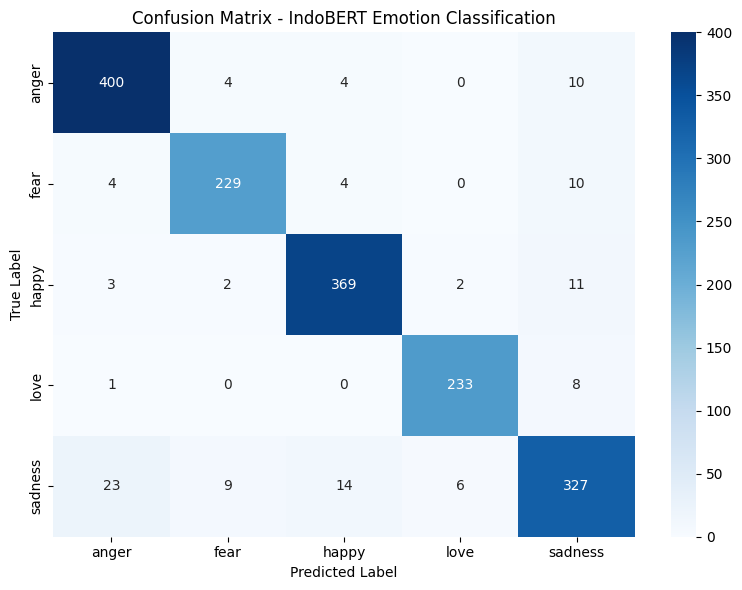

In [24]:
import pandas as pd
import re
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from imblearn.over_sampling import RandomOverSampler

# 1. MEMUAT DAN MENGGABUNGKAN SEMUA DATA
try:
    # Muat semua dataset
    df_lama = pd.read_csv("/content/Twitter_Emotion_Dataset.csv")
    df_baru_train = pd.read_csv("/content/train_preprocess.csv")
    df_baru_valid = pd.read_csv("/content/valid_preprocess.csv")
    print("Berhasil memuat 3 file dataset.")

    # Gabungkan ketiga DataFrame menjadi satu
    df_gabungan = pd.concat([df_lama, df_baru_train, df_baru_valid], ignore_index=True)
    print(f"\nUkuran dataset gabungan: {len(df_gabungan)} baris")
    print("\nDistribusi label pada dataset gabungan:")
    print(df_gabungan['label'].value_counts())

except FileNotFoundError as e:
    print(f"Error: File tidak ditemukan. Pastikan nama file sudah benar. Detail: {e}")
    exit()

# 2. PREPROCESSING
try:
    alay_df = pd.read_csv('kamus_alay.csv')
    alay_dict = dict(zip(alay_df['slang'], alay_df['formal']))
    print("\nKamus alay berhasil dimuat.")
except FileNotFoundError:
    print("Peringatan: kamus_alay.csv tidak ditemukan. Normalisasi kata alay tidak akan dilakukan.")
    alay_dict = {}

# Fungsi preprocessing
def preprocess_for_bert(tweet: str, alay_dict: dict) -> str:
    tweet = str(tweet)
    tweet = tweet.lower() # Case folding
    tweet = re.sub(r'\[url\]|\[username\]|#\w+|\d+', '', tweet) # Cleansing
    tweet = re.sub(r'[^\w\s]', '', tweet) # Hapus tanda baca
    tokens = tweet.split()
    normalized_tokens = [alay_dict.get(token, token) for token in tokens] # Normalisasi kata alay/slang
    return ' '.join(normalized_tokens)

print("Memulai preprocessing pada data gabungan...")
df_gabungan['cleaned_tweet'] = df_gabungan['tweet'].apply(lambda x: preprocess_for_bert(x, alay_dict))

# Mengubah label teks menjadi angka
labels = sorted(df_gabungan['label'].unique().tolist())
label_map = {label: i for i, label in enumerate(labels)}
df_gabungan['label_encoded'] = df_gabungan['label'].map(label_map)
print("Preprocessing selesai.")

# 3. MEMBAGI DATA DAN OVERSAMPLING
X_train, X_val, y_train, y_val = train_test_split(
    df_gabungan['cleaned_tweet'].tolist(),
    df_gabungan['label_encoded'].tolist(),
    test_size=0.2, # Tetap menggunakan 20% dari data gabungan sebagai validation set
    random_state=42,
    stratify=df_gabungan['label_encoded'].tolist()
)

print("\n--- Menerapkan Random Oversampling pada Data Latih ---")
ros = RandomOverSampler(random_state=42)
X_train_reshaped = np.array(X_train).reshape(-1, 1)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_reshaped, y_train)
X_train_resampled = X_train_resampled.flatten().tolist()
print(f"Ukuran data latih setelah oversampling: {len(X_train_resampled)}")

# 4. TOKENISASI DAN MEMBUAT DATASET
model_name = 'indobenchmark/indobert-base-p1'
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(X_train_resampled, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=128)

class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = EmotionDataset(train_encodings, y_train_resampled)
val_dataset = EmotionDataset(val_encodings, y_val)

# 5. FINE-TUNING INDOBERT DENGAN SETELAN TERBAIK
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(labels))

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    return {'accuracy': accuracy}

training_args = TrainingArguments(
    output_dir='./results_final',
    num_train_epochs=5,
    learning_rate=1e-5, # Learning rate rendah
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_steps=100, # Disesuaikan karena data latih lebih besar
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print("\nMemulai proses fine-tuning IndoBERT pada DATA GABUNGAN...")
trainer.train()
print("Fine-tuning selesai.")

# 6. EVALUASI
print("\n--- Mengevaluasi model terbaik pada data validasi ---")
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

print("\nLaporan Klasifikasi Final (pada Data Gabungan):")
print(classification_report(y_val, preds, target_names=labels))

# 7. CONFUSION MATRIX
cm = confusion_matrix(y_val, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - IndoBERT Emotion Classification")
plt.tight_layout()
plt.show()

Penjelasan: Ditambahkan data baru sebanyak sekitar 4000 data, sehingga menghasilkan data gabungan sebanyak 8362 data. Penambahan data ini dilakukan agar model dapat belajar dengan lebih maksimal menggunakan data yang mengandung informasi baru mengenai karakteristik masing-masing emosi.

Hasilnya, akurasi model ini mencapai 93%, meningkat sangat signifikan dari model sebelumnya tanpa penambahan data.

Semua kelas mendapatkan skor 0.9, kecuali sadness yang hanya sektar 0.8, tetapi itu juga peningkatan yang sangat tinggi dibandingkan sebelumnya.

### Kesimpulan

Model terbaik untuk mengklasifikasikan emosi pada dataset ini adalah IndoBERT dengan menggunakan random oversampling dan dengan menambah data baru, serta tuning model dengan learning rate rendah dan epoch yang diperbanyak. Model ini mencapai akurasi 93% dengan skor keseluruhan yang seimbang pada semua kelas, serta tidak terjadi overfitting.

Ketika digunakan model IndoBERT tanpa penambahan data baru, akurasinya mencapai 73%, yang mana juga paling tinggi di antara model lain, yang berarti model ini merupakan model yang kinerjanya paling optimal. Oleh karena itu, diputuskan untuk menambahkan data baru menggunakan IndoBERT, agar model dapat lebih banyak mempelajari pola data yang kompleks, sehingga model dapat lebih memahami karakteristik tiap label.